In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import random
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.models import load_model,Sequential,Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

In [2]:
#载入训练数据
path='dataset/processed_dataset/train/'
train_data=pd.read_csv(path+'processed_bop_train.csv',index_col=0,low_memory=False)
test_data=pd.read_csv(path+'processed_bop_test.csv',index_col=0,low_memory=False)

train_data['log_revenue']=np.log1p(train_data['revenue'])
test_data['log_revenue']=np.log1p(test_data['revenue'])

train_x=train_data.drop(['revenue','log_revenue',],axis=1)
train_y=train_data['log_revenue']
test_x=test_data.drop(['revenue','log_revenue'],axis=1)
test_y=test_data['log_revenue']

In [3]:
#创建模型结构
for k in [5, 20, 50]:  # 网格搜索超参数：神经元数k

    model = Sequential()

    model.add(BatchNormalization(input_dim=17))  # 输入层 批标准化

    model.add(Dense(k,
                    kernel_initializer='random_uniform',  # 均匀初始化
                    activation='relu',  # relu激活函数
                    kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),  # L1及L2 正则项
                    use_bias=True))              # 隐藏层
    
    model.add(Dropout(0.1))  # dropout法
    
    model.add(Dense(1, use_bias=True))           # 输出层

    model.compile(optimizer='adam', loss='mse')  #设定学习目标为（最小化）回归预测损失mse，优化算法为adam

验证集最优结果： 9.311627388000488
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 17)               68        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 50)                900       
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,019
Trainable params: 985
Non-trainable params: 34
_________________________________________________________________


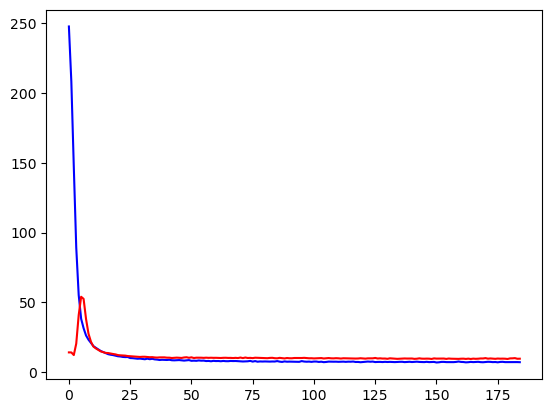

In [4]:
model1 = model.fit(train_x,
                    train_y,
                    epochs=500,  # 训练迭代次数
                    batch_size=50,  # 每epoch采样的batch大小
                    validation_split=0.05,  # 从训练集再拆分验证集，作为早停的衡量指标
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)],  # 早停法
                    verbose=False)  # 不输出过程
model.save('model1.h5')  #保存模型及参数
print("验证集最优结果：", min(model1.history['val_loss']))
model.summary()  # 打印模型概述信息
# 模型评估：拟合效果
plt.plot(model1.history['loss'], c='blue')  # 蓝色线训练集损失
plt.plot(model1.history['val_loss'], c='red')  # 红色线验证集损失
plt.show()

In [5]:
# 模型评估：测试集预测结果
pred_y = model.predict(test_x)[:,0]
#print("正确标签：",test_y)
#print("模型预测：",pred_y)
model_rmsle = np.sqrt(mean_squared_error(test_y, pred_y))
model_rmsle
print("深度学习模型的rmsle值为：",model_rmsle)

16/16 [==============================] - 0s 2ms/step
深度学习模型的rmsle值为： 2.0813713774576392


实际与预测值的mae： 1.5161642102457153


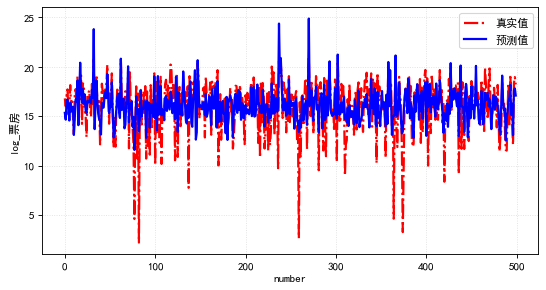

In [6]:
#预测结果可视化
#print("实际与预测值的差异：",mean_squared_error(test_y,pred_y ))
print("实际与预测值的mae：",mean_absolute_error(test_y,pred_y ))

#绘图表示
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置图形大小
plt.figure(figsize=(8, 4), dpi=80)
plt.plot(range(len(test_y)), test_y, ls='-.',lw=2,c='r',label='真实值')
plt.plot(range(len(pred_y)), pred_y, ls='-',lw=2,c='b',label='预测值')

# 绘制网格
plt.grid(alpha=0.4, linestyle=':')
plt.legend()
plt.xlabel('number') #设置x轴的标签文本
plt.ylabel('log_票房') #设置y轴的标签文本

# 展示
plt.savefig('deep_learining_predictions_1.png')
plt.show()

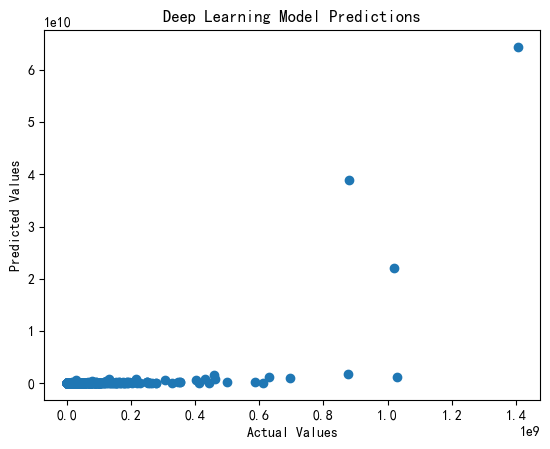

In [7]:
test_y=np.exp(test_y)
pred_y=np.exp(pred_y)

plt.scatter(test_y, pred_y)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Deep Learning Model Predictions')
plt.savefig('deep_learining_predictions_2.png')
plt.show()